<a href="https://colab.research.google.com/github/frankwillard/NBA-Web-Scraper-And-ANN/blob/main/TensorFlow_NBA_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow NBA Champion Neural Network

Inspired by the TensorFlow tutorial on working with Imbalanced Data

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
tf.__version__

'2.8.0'

## Part 1 - Data Preprocessing

### Importing and viewing the dataset

In [3]:
dataset = pd.read_csv('nba_team_advanced_data.csv')
dataset.head()

,Year,Team,Age,W,L,PW,PL,MOV,SOS,SRS,...,DRB%,DFT/FGA,Arena,Attend.,Playoffs,W/L%,Losing_season,Champion,won_last,won_last_3
0,1990.0,Atlanta Hawks,28.6,41.0,41.0,44.0,38.0,1.02,-0.39,0.64,...,65.5,0.254,Omni Coliseum,573711.0,N,0.500000,N,N,N,N
1,1990.0,Boston Celtics,30.2,52.0,30.0,51.0,31.0,3.99,-0.76,3.23,...,72.1,0.223,Boston Garden,611537.0,N,0.634146,N,N,N,N
2,1990.0,Charlotte Hornets,25.6,19.0,63.0,21.0,61.0,-7.82,0.81,-7.00,...,67.5,0.269,Charlotte Coliseum,979941.0,N,0.231707,Y,N,N,N
3,1990.0,Chicago Bulls,26.1,55.0,27.0,50.0,32.0,3.26,-0.51,2.74,...,68.1,0.262,Chicago Stadium,752564.0,N,0.670732,N,N,N,N
4,1990.0,Cleveland Cavaliers,26.1,42.0,40.0,40.0,42.0,-0.30,-0.31,-0.62,...,67.7,0.202,Coliseum at Richfield,695710.0,N,0.512195,N,N,N,N


In [4]:
dataset = dataset.drop(columns=['Playoffs', 'Losing_season', 'Arena', 'L', 'W', 'PW', 'PL', 'Attend.'])

In [5]:
dataset.columns

Index(['Year', 'Team', 'Age', 'MOV', 'SOS', 'SRS', 'ORtg', 'DRtg', 'NRtg',
       'Pace', 'FTr', '3PAr', 'TS%', 'OeFG%', 'OTOV%', 'ORB%', 'OFT/FGA',
       'DeFG%', 'DTOV%', 'DRB%', 'DFT/FGA', 'W/L%', 'Champion', 'won_last',
       'won_last_3'],
      dtype='object')

In [6]:
#Drop Year, Champion, Team
X = dataset.iloc[:, ~ dataset.columns.isin(['Year', 'Champion', 'Team'])]
y = dataset.loc[:, dataset.columns == 'Champion'].values
y = np.array([0 if val == "N" else 1 for val in y])

### Identifying Class Imbalance

In [7]:
neg, pos = np.bincount(y)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 903
    Positive: 31 (3.43% of total)



### Encode Categorical Values

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
#3 because want to one hot encode State variable
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['won_last', 'won_last_3'])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

### Splitting the dataset into the Training set and Test set

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y,train_size=0.7, test_size=0.25, random_state=7)

### Feature Scaling

In [11]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
#X_test = sc.transform(X_test)

### Checking Dimensions of Inputs

In [12]:
print('Training labels shape:', y_train.shape)
print('Validation labels shape:', y_val.shape)

print('Training features shape:', X_train.shape)
print('Validation features shape:', X_val.shape)

Training labels shape: (632,)
Validation labels shape: (226,)
Training features shape: (632, 24)
Validation features shape: (226, 24)


## Part 2 - Building the Baseline ANN

### Setting Model Hyperparameters

In [13]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [14]:
opt = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryCrossentropy()
input_shape = X_train.shape[-1]

In [15]:
#!pip install tensorflow_addons
#import tensorflow_addons as tfa
#fl = tfa.losses.SigmoidFocalCrossEntropy(alpha=0.0001, gamma=2.0)

In [16]:
tf.random.set_seed(0)

### Building the Model

In [17]:
def create_model(input_shape = input_shape, metrics=METRICS, optimizer= opt, loss_function = loss, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  ann = tf.keras.models.Sequential()
  ann.add(tf.keras.layers.Dense(input_shape = (input_shape, ), units=200, activation='relu'))
  ann.add(tf.keras.layers.BatchNormalization())
  ann.add(tf.keras.layers.Dropout(0.4))
  ann.add(tf.keras.layers.Dense(units=100, activation='relu'))
  ann.add(tf.keras.layers.BatchNormalization())
  ann.add(tf.keras.layers.Dropout(0.4))
  ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid', bias_initializer = output_bias))
  ann.compile(optimizer = opt, loss = loss_function, metrics=metrics)
  return ann

### Further Defining Model Hyperparameters

In [18]:
EPOCHS = 200
BATCH_SIZE = 16
val_data = (X_val, y_val)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor ="val_prc", 
                                        mode ="max", patience = 5, 
                                        restore_best_weights = True)

### Defining an Initial Bias (Based on the Log Odds of the Response Variable)

In [19]:
initial_bias = np.log([pos/neg])

### Summarizing the Model

In [20]:
model = create_model(output_bias = initial_bias)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               5000      
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 batch_normalization_1 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 100)               0

### Saving the Initial Weights

In [21]:
import tempfile
import os

In [22]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

### Determining the Effectiveness of Log Odds Bias

In [23]:
model = create_model()
model.load_weights(initial_weights)
#KEY DIFFERENCE- 0 BIAS
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=val_data, 
    verbose=0)

In [24]:
model = create_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=val_data, 
    verbose=0)

#### Plotting the Losses

In [25]:
import matplotlib.pyplot as plt

In [26]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [27]:
#Function from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#confirm_that_the_bias_fix_helps
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

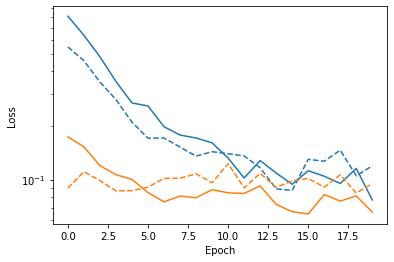

In [28]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

It is clear from the visualization that the initial bias reduces the loss, such that we include it in our baseline model

### Running the Baseline Model

In [29]:
model = create_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[earlystopping],
    validation_data=val_data)

Epoch 1/200
40/40 [==============================] - 4s 34ms/step - loss: 0.1629 - tp: 7.0000 - fp: 20.0000 - tn: 809.0000 - fn: 22.0000 - accuracy: 0.9510 - precision: 0.2593 - recall: 0.2414 - auc: 0.8171 - prc: 0.2547 - val_loss: 0.0816 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 221.0000 - val_fn: 4.0000 - val_accuracy: 0.9823 - val_precision: 1.0000 - val_recall: 0.2000 - val_auc: 0.9154 - val_prc: 0.2941
Epoch 2/200
40/40 [==============================] - 0s 5ms/step - loss: 0.1637 - tp: 5.0000 - fp: 13.0000 - tn: 595.0000 - fn: 19.0000 - accuracy: 0.9494 - precision: 0.2778 - recall: 0.2083 - auc: 0.7402 - prc: 0.2089 - val_loss: 0.1078 - val_tp: 1.0000 - val_fp: 7.0000 - val_tn: 214.0000 - val_fn: 4.0000 - val_accuracy: 0.9513 - val_precision: 0.1250 - val_recall: 0.2000 - val_auc: 0.8977 - val_prc: 0.2825
Epoch 3/200
40/40 [==============================] - 0s 6ms/step - loss: 0.1118 - tp: 4.0000 - fp: 5.0000 - tn: 603.0000 - fn: 20.0000 - accuracy: 0.9604 - precision: 0.

### Plotting the Metrics of Baseline Model

In [30]:
#Function from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#confirm_that_the_bias_fix_helps

def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

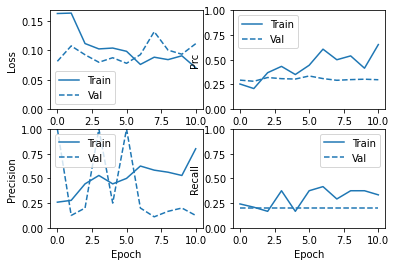

In [31]:
plot_metrics(baseline_history)

In [32]:
train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_val, batch_size=BATCH_SIZE)

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [34]:
#Function from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#confirm_that_the_bias_fix_helps

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Champions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Champions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Non Champions Missed (False Negatives): ', cm[1][0])
  print('Non Champions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.07813606411218643
tp :  1.0
fp :  0.0
tn :  221.0
fn :  4.0
accuracy :  0.982300877571106
precision :  1.0
recall :  0.20000000298023224
auc :  0.9022624492645264
prc :  0.3361627459526062

Legitimate Champions Detected (True Negatives):  221
Legitimate Champions Incorrectly Detected (False Positives):  0
Non Champions Missed (False Negatives):  4
Non Champions Detected (True Positives):  1
Total Fraudulent Transactions:  5


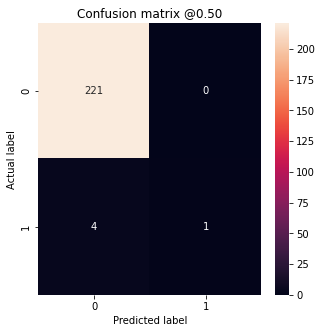

In [35]:
baseline_results = model.evaluate(X_val, y_val,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_val, test_predictions_baseline)

In [36]:
import sklearn

In [37]:
#Function from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#confirm_that_the_bias_fix_helps
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([50,100.5])
  plt.grid(True)
  ax = plt.gca()
  #ax.set_aspect('equal')

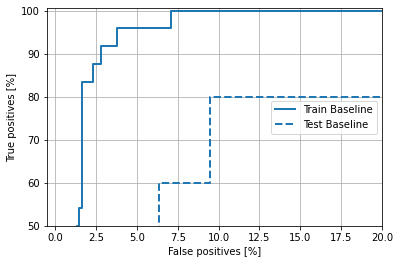

In [38]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_val, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='center right');

In [39]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

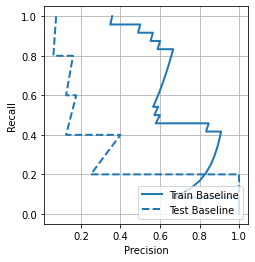

In [40]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_val, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

## Part 3- Weighted Model

### Introducing Class Weights

In [41]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.52
Weight for class 1: 14.56


### Running the Weighted Model

In [42]:
weighted_model = create_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[earlystopping],
    validation_data=val_data,
    # The class weights go here
    class_weight=class_weight)

Epoch 1/200
40/40 [==============================] - 4s 36ms/step - loss: 0.6121 - tp: 19.0000 - fp: 71.0000 - tn: 758.0000 - fn: 10.0000 - accuracy: 0.9056 - precision: 0.2111 - recall: 0.6552 - auc: 0.8855 - prc: 0.2684 - val_loss: 0.4185 - val_tp: 3.0000 - val_fp: 40.0000 - val_tn: 181.0000 - val_fn: 2.0000 - val_accuracy: 0.8142 - val_precision: 0.0698 - val_recall: 0.6000 - val_auc: 0.8810 - val_prc: 0.1131
Epoch 2/200
40/40 [==============================] - 0s 7ms/step - loss: 0.6509 - tp: 18.0000 - fp: 94.0000 - tn: 514.0000 - fn: 6.0000 - accuracy: 0.8418 - precision: 0.1607 - recall: 0.7500 - auc: 0.8662 - prc: 0.1843 - val_loss: 0.4999 - val_tp: 3.0000 - val_fp: 32.0000 - val_tn: 189.0000 - val_fn: 2.0000 - val_accuracy: 0.8496 - val_precision: 0.0857 - val_recall: 0.6000 - val_auc: 0.8557 - val_prc: 0.0816
Epoch 3/200
40/40 [==============================] - 0s 7ms/step - loss: 0.3493 - tp: 22.0000 - fp: 96.0000 - tn: 512.0000 - fn: 2.0000 - accuracy: 0.8449 - precision: 0.

### Plotting the Metrics of Weighted Model

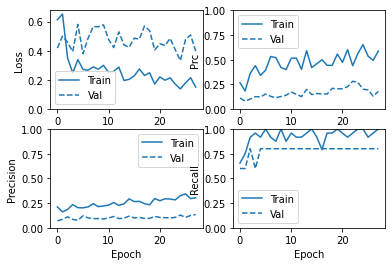

In [43]:
plot_metrics(weighted_history)

In [44]:
train_predictions_weighted = weighted_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(X_val, batch_size=BATCH_SIZE)

loss :  0.4847976565361023
tp :  4.0
fp :  36.0
tn :  185.0
fn :  1.0
accuracy :  0.8362832069396973
precision :  0.10000000149011612
recall :  0.800000011920929
auc :  0.9199095368385315
prc :  0.2826690673828125

Legitimate Champions Detected (True Negatives):  185
Legitimate Champions Incorrectly Detected (False Positives):  36
Non Champions Missed (False Negatives):  1
Non Champions Detected (True Positives):  4
Total Fraudulent Transactions:  5


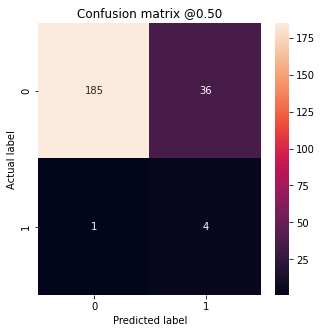

In [45]:
weighted_results = weighted_model.evaluate(X_val, y_val,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_val, test_predictions_weighted)

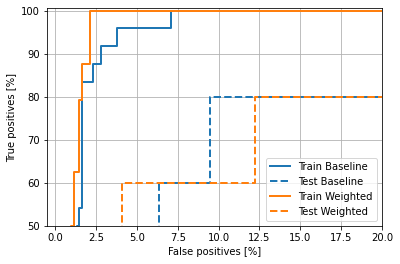

In [46]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_val, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_val, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

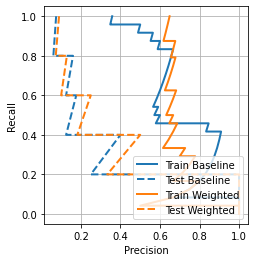

In [47]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_val, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y_val, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

## Part 4- Oversampled Model

### Determining positive and negative labels

In [48]:
bool_train_labels = y_train != 0

In [49]:
pos_X_train = X_train[bool_train_labels]
neg_X_train = X_train[~bool_train_labels]

pos_y_train = y_train[bool_train_labels]
neg_y_train = y_train[~bool_train_labels]

### Resampling positive samples to even out representation

In [50]:
ids = np.arange(len(pos_X_train))
choices = np.random.choice(ids, len(neg_X_train))

res_pos_X_train = pos_X_train[choices]
res_pos_y_train = pos_y_train[choices]

res_pos_X_train.shape

(608, 24)

### Defining dataset with resampled data and shuffling it

In [51]:
resampled_features = np.concatenate([res_pos_X_train, neg_X_train], axis=0)
resampled_labels = np.concatenate([res_pos_y_train, neg_y_train], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(1216, 24)

### Building the Resampled Model

In [52]:
resampled_model = create_model()
resampled_model.load_weights(initial_weights)

In [53]:
# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

<tf.Variable 'UnreadVariable' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>

In [54]:
val_ds = tf.data.Dataset.from_tensor_slices(val_data).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

### Redefining epoch (number of batches to see each negative sample)

In [55]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)

### Running the Resampled Model

In [56]:
resampled_history = resampled_model.fit(
    resampled_features,
    resampled_labels,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[earlystopping],
    validation_data=val_ds)

Epoch 1/200
109/109 [==============================] - 4s 14ms/step - loss: 0.2750 - tp: 600.0000 - fp: 118.0000 - tn: 751.0000 - fn: 57.0000 - accuracy: 0.8853 - precision: 0.8357 - recall: 0.9132 - auc: 0.9487 - prc: 0.9165 - val_loss: 0.6147 - val_tp: 4.0000 - val_fp: 48.0000 - val_tn: 173.0000 - val_fn: 1.0000 - val_accuracy: 0.7832 - val_precision: 0.0769 - val_recall: 0.8000 - val_auc: 0.8977 - val_prc: 0.1480
Epoch 2/200
109/109 [==============================] - 0s 4ms/step - loss: 0.2097 - tp: 606.0000 - fp: 58.0000 - tn: 603.0000 - fn: 33.0000 - accuracy: 0.9300 - precision: 0.9127 - recall: 0.9484 - auc: 0.9689 - prc: 0.9466 - val_loss: 0.3437 - val_tp: 4.0000 - val_fp: 29.0000 - val_tn: 192.0000 - val_fn: 1.0000 - val_accuracy: 0.8673 - val_precision: 0.1212 - val_recall: 0.8000 - val_auc: 0.8928 - val_prc: 0.2081
Epoch 3/200
109/109 [==============================] - 0s 4ms/step - loss: 0.1938 - tp: 635.0000 - fp: 45.0000 - tn: 592.0000 - fn: 28.0000 - accuracy: 0.9438 - p

### Plotting Metrics of Resampled Model

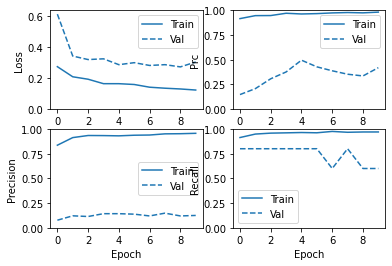

In [57]:
plot_metrics(resampled_history)

### Decreasing steps_per_epoch to reduce overfitting (let early stopping prevent it)

In [58]:
resampled_history = resampled_model.fit(
    resampled_features,
    resampled_labels,    
    steps_per_epoch=20,# These are not real epochs
    epochs=10*EPOCHS,
    callbacks=[earlystopping],
    validation_data=(val_ds))

Epoch 1/2000
20/20 [==============================] - 0s 9ms/step - loss: 0.0979 - tp: 607.0000 - fp: 26.0000 - tn: 582.0000 - fn: 1.0000 - accuracy: 0.9778 - precision: 0.9589 - recall: 0.9984 - auc: 0.9916 - prc: 0.9868 - val_loss: 0.2934 - val_tp: 4.0000 - val_fp: 23.0000 - val_tn: 198.0000 - val_fn: 1.0000 - val_accuracy: 0.8938 - val_precision: 0.1481 - val_recall: 0.8000 - val_auc: 0.9204 - val_prc: 0.4105
Epoch 2/2000
20/20 [==============================] - 0s 10ms/step - loss: 0.0851 - tp: 608.0000 - fp: 27.0000 - tn: 581.0000 - fn: 0.0000e+00 - accuracy: 0.9778 - precision: 0.9575 - recall: 1.0000 - auc: 0.9928 - prc: 0.9899 - val_loss: 0.2928 - val_tp: 4.0000 - val_fp: 23.0000 - val_tn: 198.0000 - val_fn: 1.0000 - val_accuracy: 0.8938 - val_precision: 0.1481 - val_recall: 0.8000 - val_auc: 0.9027 - val_prc: 0.3721
Epoch 3/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0931 - tp: 606.0000 - fp: 24.0000 - tn: 584.0000 - fn: 2.0000 - accuracy: 0.9786 - prec

### Plotting Metrics of Final Resampled Model

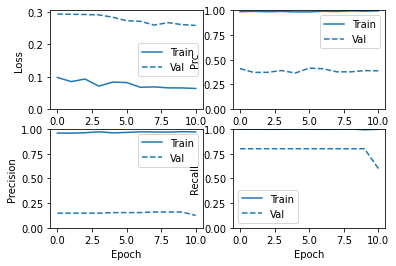

In [59]:
plot_metrics(resampled_history)


In [60]:
train_predictions_resampled = resampled_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(X_val, batch_size=BATCH_SIZE)

loss :  0.27275726199150085
tp :  4.0
fp :  22.0
tn :  199.0
fn :  1.0
accuracy :  0.8982300758361816
precision :  0.1538461595773697
recall :  0.800000011920929
auc :  0.9085972905158997
prc :  0.4153599739074707

Legitimate Champions Detected (True Negatives):  199
Legitimate Champions Incorrectly Detected (False Positives):  22
Non Champions Missed (False Negatives):  1
Non Champions Detected (True Positives):  4
Total Fraudulent Transactions:  5


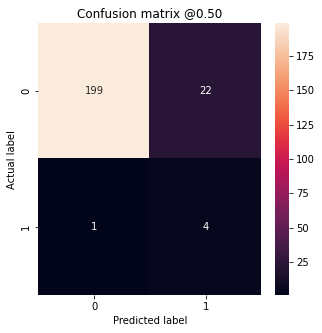

In [61]:
resampled_results = resampled_model.evaluate(X_val, y_val,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(y_val, test_predictions_resampled)

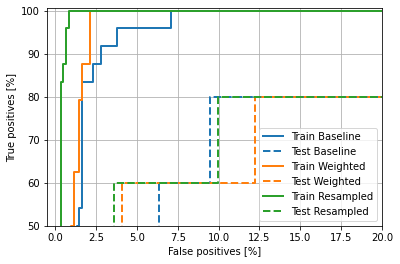

In [62]:

plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_val, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_val, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", y_train, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", y_val, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

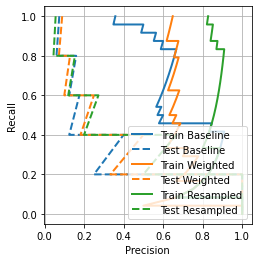

In [63]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_val, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y_val, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", y_train, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", y_val, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

### Evaluating Performance on Training Set

In [64]:
'''
#Code that will iterate over all years and determine the team with max output from NN

years = np.arange(1990.0,2020.0)

row_list = []

for year in years:

  year_df = test_df[test_df["Year"] == year]
  year_df.reset_index()
  max_idx = pd.to_numeric(year_df["Prediction"]).idxmax()
  row_list.append(dict(test_df.iloc[max_idx]))

max_year_df = pd.DataFrame(row_list, columns = ['Year', 'Team', 'Prediction', 'True'])

'''

'\n#Code that will iterate over all years and determine the team with max output from NN\n\nyears = np.arange(1990.0,2020.0)\n\nrow_list = []\n\nfor year in years:\n\n  year_df = test_df[test_df["Year"] == year]\n  year_df.reset_index()\n  max_idx = pd.to_numeric(year_df["Prediction"]).idxmax()\n  row_list.append(dict(test_df.iloc[max_idx]))\n\nmax_year_df = pd.DataFrame(row_list, columns = [\'Year\', \'Team\', \'Prediction\', \'True\'])\n\n'

## Part 5- Predicting the 2022 Playoffs

### Data Processing

In [65]:
test_data = pd.read_csv('2022_advanced_data.csv')

In [67]:
test_data = test_data.drop(columns=['Playoffs', 'Losing_season', 'Arena', 'L', 'W', 'PW', 'PL', 'Attend.'])

In [68]:
X_test = test_data.iloc[:, ~ test_data.columns.isin(['Year', 'Champion', 'Team'])]
y_test = test_data.loc[:, test_data.columns == 'Champion'].values
y_test = np.array([0 if val == "N" else 1 for val in y_test])

In [69]:
X_test = np.array(ct.transform(X_test))

In [70]:
X_test = sc.transform(X_test)

### Making Predictions

In [71]:
test_predictions = resampled_model.predict(X_test)

### Organizing the Data

In [76]:
test_arrays = np.column_stack([test_data["Year"], test_data["Team"], test_predictions.flatten()])
test_df = pd.DataFrame(test_arrays, columns = ['Year', 'Team', 'Prediction'])

In [77]:
test_df.sort_values(by=['Prediction'], ascending=False)

,Year,Team,Prediction
23,2022.0,Phoenix Suns,0.994112
16,2022.0,Milwaukee Bucks,0.914403
15,2022.0,Miami Heat,0.882326
9,2022.0,Golden State Warriors,0.868706
1,2022.0,Boston Celtics,0.301564
28,2022.0,Utah Jazz,0.282237
7,2022.0,Denver Nuggets,0.132514
14,2022.0,Memphis Grizzlies,0.095259
2,2022.0,Brooklyn Nets,0.060666
6,2022.0,Dallas Mavericks,0.021669


Based on the model, the teams with output scores > 0.5 are the Suns, Bucks, Heat, and Warriors. Based on the magnitude of the scores, we would assume the Suns will win the Championship. 